In [2]:
import os
import glob
import shutil

In [3]:
img_num = [111, 114, 42, 120, 121, 27, 30, 92]

In [4]:
for img in img_num:
    img_source = f"./selected images/{img}.jpg"
    img_targe = f"./imgsClassification/difficult/"
    shutil.copy(img_source, img_targe)

## 1. Number of segmented regions

In [20]:
import pickle
from tqdm import tqdm

In [21]:
image_num = [55, 6, 33, 90, 99, 104, 66, 95, 4, 65, 105, 3, 32, 28, 39, 46, 85, 110, 18, 73, 74, 87, 
             98, 19, 44, 54, 78, 86, 25, 52, 83, 61, 75, 21, 112, 34, 38, 47, 109, 49, 79, 80, 81, 82, 
             88, 101, 103, 62, 124, 1, 108, 45, 68, 71, 84, 106, 60, 11, 56, 63, 96, 9, 72, 126, 16, 
             20, 76, 89, 102, 116, 123, 50, 53, 57, 77, 93, 97, 37, 64, 24, 29, 117, 70, 35, 48, 125, 
             14, 17, 113, 23, 40, 94, 111, 114, 42, 120, 121, 27, 30, 92]

In [22]:
def getInfoFromFolder(pkl_root,includeTree_root,keepNode_root):
    
    with open(pkl_root, "rb") as fp:
        results = pickle.load(fp)

    sorted_masks = results["sorted_masks"]
    used_img = results["img_opencv"]

    with open(includeTree_root, "rb") as fp:
        results = pickle.load(fp)

    includeTree = results["includeTree"]

    with open(keepNode_root, "rb") as fp:
        results = pickle.load(fp)

    updated_tree = results["updated_tree"]
    ancestors_node = results["ancestors_node"]
    children_box_node = results["children_box_node"]

    return {
        "sorted_masks":sorted_masks,
        "used_img":used_img,
        "includeTree":includeTree,
        "updated_tree":updated_tree,
        "ancestors_node":ancestors_node,
        "children_box_node":children_box_node
    }

In [19]:
total_num = 0
for img_id in tqdm(image_num):
    pkl_root = f"./results/1. sam_masks/pkl_info/{img_id}.pkl"
    includeTree_root = f"./results/1. sam_masks/includeTree_info/{img_id}.pkl"
    keepNode_root = f"./results/1. sam_masks/keep_node_info/{img_id}.pkl"
    
    results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)
    
    sorted_masks = results["sorted_masks"]
    used_img = results["used_img"]
    includeTree = results["includeTree"]
    updated_tree = results["updated_tree"]
    ancestors_node = results["ancestors_node"]
    children_box_node = results["children_box_node"]
    total_num += len(sorted_masks)

NameError: name 'tqdm' is not defined

In [25]:
print(total_num)

21564


## 2. 计算图片的熵/GLCM/方差等

In [5]:
from PIL import Image
import numpy as np
import math
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte

In [6]:
def calculate_glcm_entropy(glcm):
    """
    计算GLCM的熵。
    
    参数:
    glcm: 灰度共生矩阵
    
    返回:
    numpy.ndarray: 每个距离和角度组合的熵
    """
    entropy_values = np.zeros((glcm.shape[2], glcm.shape[3]))
    
    for d in range(glcm.shape[2]):
        for a in range(glcm.shape[3]):
            # 获取当前GLCM
            current_glcm = glcm[:, :, d, a].copy()
            
            # 避免log(0)问题
            current_glcm = current_glcm[current_glcm > 0]
            
            # 计算熵 (-sum(p * log(p)))
            entropy = -np.sum(current_glcm * np.log2(current_glcm))
            entropy_values[d, a] = entropy
    
    return entropy_values

In [7]:
def extract_glcm_features(image_path, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    """
    提取图像的GLCM特征。
    
    参数:
    image_path (str): 图像文件路径
    distances (list): 像素对之间的距离
    angles (list): 计算GLCM的角度
    levels (int): 灰度级别数量
    symmetric (bool): 是否使用对称GLCM
    normed (bool): 是否归一化GLCM
    
    返回:
    dict: 包含GLCM特征的字典
    """
    # 读取图像
    image = io.imread(image_path)
    
    # 如果图像是彩色的，转换为灰度图
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    
    # 转换为无符号8位整数格式
    image = img_as_ubyte(image)
    
    # 计算GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, 
                        levels=levels, symmetric=symmetric, normed=normed)
    
    # 提取GLCM特征
    features = {}
    
    # 计算对比度
    contrast = graycoprops(glcm, 'contrast')
    features['contrast'] = contrast
    
    # 计算相异性
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    features['dissimilarity'] = dissimilarity
    
    # 计算同质性
    homogeneity = graycoprops(glcm, 'homogeneity')
    features['homogeneity'] = homogeneity
    
    # 计算能量
    energy = graycoprops(glcm, 'energy')
    features['energy'] = energy
    
    # 计算相关性
    correlation = graycoprops(glcm, 'correlation')
    features['correlation'] = correlation
    
    # 计算ASM (Angular Second Moment)
    ASM = graycoprops(glcm, 'ASM')
    features['ASM'] = ASM

    entropy = calculate_glcm_entropy(glcm)
    features['entropy'] = entropy

    contrast_m = np.mean(contrast)
    dissimilarity_m = np.mean(dissimilarity)
    homogeneity_m = np.mean(homogeneity)
    energy_m = np.mean(energy)
    correlation_m = np.mean(correlation)
    entropy_m = np.mean(entropy)
    
    complexity_index = complexity_index = (contrast_m + dissimilarity_m + entropy_m) - (homogeneity_m + energy_m + max(0, correlation_m))
    features['complexity_index'] = complexity_index
    # 计算GLCM的特征值
    eigenvalues = {}
    for d_idx, d in enumerate(distances):
        for a_idx, a in enumerate(angles):
            # 获取当前距离和角度的GLCM
            current_glcm = glcm[:, :, d_idx, a_idx]
            # 计算特征值
            eig_vals = np.linalg.eigvals(current_glcm)
            eigenvalues[f'd{d}_a{a}'] = eig_vals
            
    features['eigenvalues'] = eigenvalues
    
    return features

In [8]:
img_features = {
    "easy":np.array([]),
    "moderate":np.array([]),
    "challenging":np.array([]),
    "difficult":np.array([])
}

In [9]:
img_idx = {
    "easy":[55, 6, 33, 90, 99, 104, 66, 95, 4, 65, 105, 3, 32, 28, 39, 46, 85, 110, 18, 73, 74, 87, 98, 19, 44, 54, 78, 86, 
            25, 52, 83, 61, 75, 21, 112, 34, 38, 47, 109, 49, 79, 80, 81, 82, 88, 101, 103, 62, 124, 1, 108],
    "moderate":[45, 68, 71, 84, 106, 60, 11, 56, 63, 96, 9, 72, 126, 16, 20, 76, 89, 102, 116, 123, 50, 53, 57, 77, 93, 97, 37],
    "challenging":[64, 24, 29, 117, 70, 35, 48, 125, 14, 17, 113, 23, 40, 94],
    "difficult":[111, 114, 42, 120, 121, 27, 30, 92]
}

In [10]:
img_features = {
    "easy":np.array([]),
    "moderate":np.array([]),
    "challenging":np.array([]),
    "difficult":np.array([])
}
for k, v in img_idx.items():
    idx_list = img_features[k]
    for img_id in v:
        img_path = f"./selected images/{img_id}.jpg"
        features = extract_glcm_features(image_path=img_path)
        idx_list = np.append(idx_list, np.mean(features["entropy"]))
    img_features[k] = idx_list

In [11]:
y_labels = ["Easy", "Moderate", "Challenging", "Difficult"]
x_labels = []
for k, v in img_features.items():
    x_labels.append(np.mean(v))

In [12]:
x_labels

[11.860939362608347, 12.262996907604979, 12.69832259441384, 12.849925641202294]

In [13]:
import matplotlib.pyplot as plt

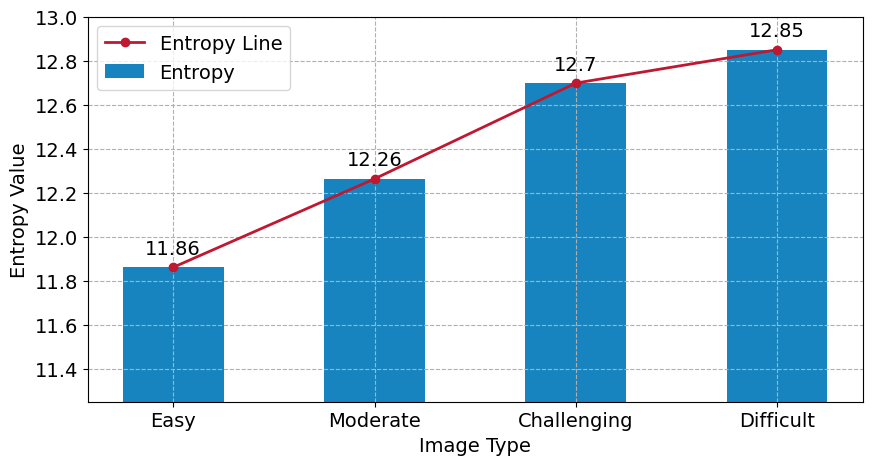

In [14]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})  # 设置字体大小为14

# 绘制条形图
plt.bar(y_labels, x_labels, width=0.5, color = "#1884BF", label="Entropy")

# 绘制折线图
plt.plot(y_labels, x_labels, color="#BF1831", marker="o", linestyle = "-", linewidth=2, label = "Entropy Line")

# 添加数值
for i, v in enumerate(x_labels):
    plt.text(i, v+0.06, str(round(v, 2)), color = "black", ha = "center")

# 添加网格
plt.grid(linestyle='--')

plt.legend()

plt.xlabel("Image Type")
plt.ylabel("Entropy Value")
plt.ylim(11.25, 13)  # 设置Y轴范围只显示数据的实际分布区间
plt.savefig('./output.svg', format='svg')
plt.show()

## 3. Model performance and image types

In [23]:
model_perf = {
    "SAM+CLIP(RN50x64)":[0.7175, 0.7322, 0.7252, 0.6963],
    "SAM+CLIP(ViT-L-14)[baseline]":[0.9704, 0.9644, 0.9579, 0.9562],
    "SAM+OpenCLIP(convnext_large_d)":[0.8611, 0.7990, 0.7275, 0.7227],
    "SAM+OpenCLIP(ViT-L-14)":[0.7744, 0.7517, 0.6753, 0.6787],
    "SAM+SigLIP(siglip-large)":[0.8136, 0.7696, 0.7044, 0.6970],
    "SAM+SigLIP(siglip-so400m)":[0.8181, 0.7716, 0.7368, 0.7407],
    "SAM+EVA-CLIP(EVA02-L-14)":[0.8961, 0.8533, 0.8006, 0.7963],
    "SAM+EVA-CLIP (EVA02-L-14-336)":[0.9021, 0.8474, 0.7851, 0.7965]
}
y_labels = ["Easy", "Moderate", "Challenging", "Difficult"]

In [24]:
bias = [-0.1,-0.1,-0.1,-0.1]

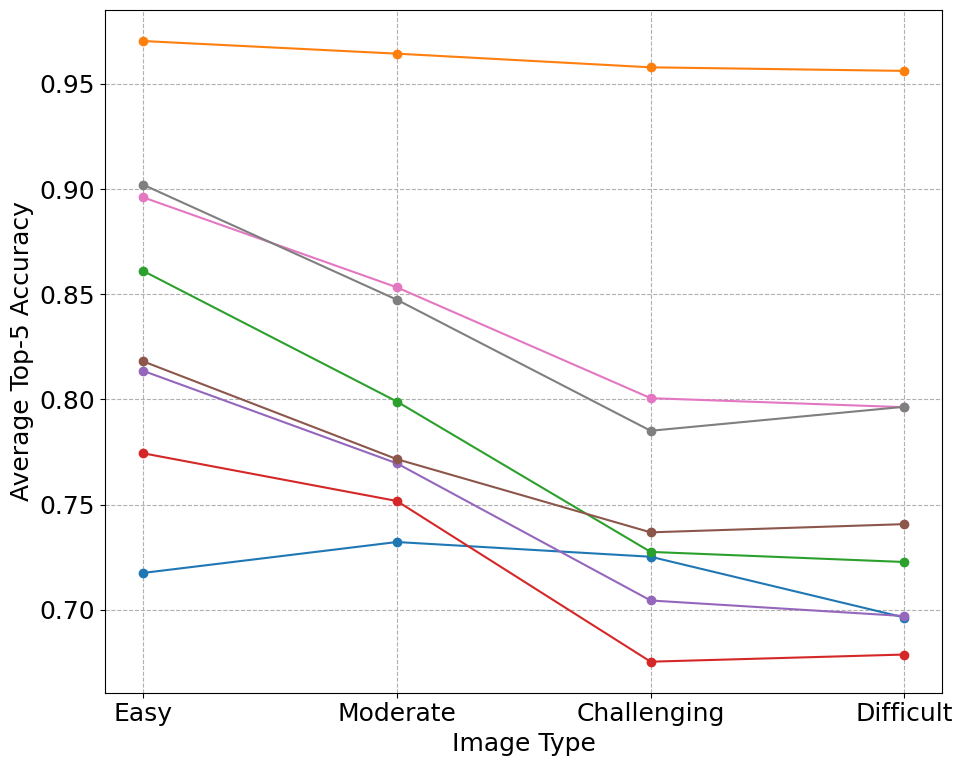

In [25]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 18})  # 设置字体大小为14

for k, v in model_perf.items():
    plt.plot(y_labels, v, marker='o', label=k)

plt.grid(linestyle='--')

plt.xlabel("Image Type")
plt.ylabel("Average Top-5 Accuracy")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()  # Adjust layout to make room for the legend

plt.savefig('./plot.svg', format='svg')

plt.show()

## 5. 像素分布

In [31]:
img_idx = {
    "easy":[55, 6, 33, 90, 99, 104, 66, 95, 4, 65, 105, 3, 32, 28, 39, 46, 85, 110, 18, 73, 74, 87, 98, 19, 44, 54, 78, 86, 
            25, 52, 83, 61, 75, 21, 112, 34, 38, 47, 109, 49, 79, 80, 81, 82, 88, 101, 103, 62, 124, 1, 108],
    "moderate":[45, 68, 71, 84, 106, 60, 11, 56, 63, 96, 9, 72, 126, 16, 20, 76, 89, 102, 116, 123, 50, 53, 57, 77, 93, 97, 37],
    "challenging":[64, 24, 29, 117, 70, 35, 48, 125, 14, 17, 113, 23, 40, 94],
    "difficult":[111, 114, 42, 120, 121, 27, 30, 92]
}

In [32]:
import matplotlib.ticker as ticker

In [33]:
area_idx = {
    "easy":[],
    "moderate":[],
    "challenging":[],
    "difficult":[]
}
for k, v in img_idx.items():
    area_list = area_idx[k]
    for img_id in v:
        pkl_root = f"./results/1. sam_masks/pkl_info/{img_id}.pkl"
        includeTree_root = f"./results/1. sam_masks/includeTree_info/{img_id}.pkl"
        keepNode_root = f"./results/1. sam_masks/keep_node_info/{img_id}.pkl"
        
        results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)
        
        sorted_masks = results["sorted_masks"]
        used_img = results["used_img"]
        includeTree = results["includeTree"]
        updated_tree = results["updated_tree"]
        ancestors_node = results["ancestors_node"]
        children_box_node = results["children_box_node"]
        for i in ancestors_node+children_box_node:
            area_list.append(sorted_masks[i]["area"])
    area_idx[k] = area_list

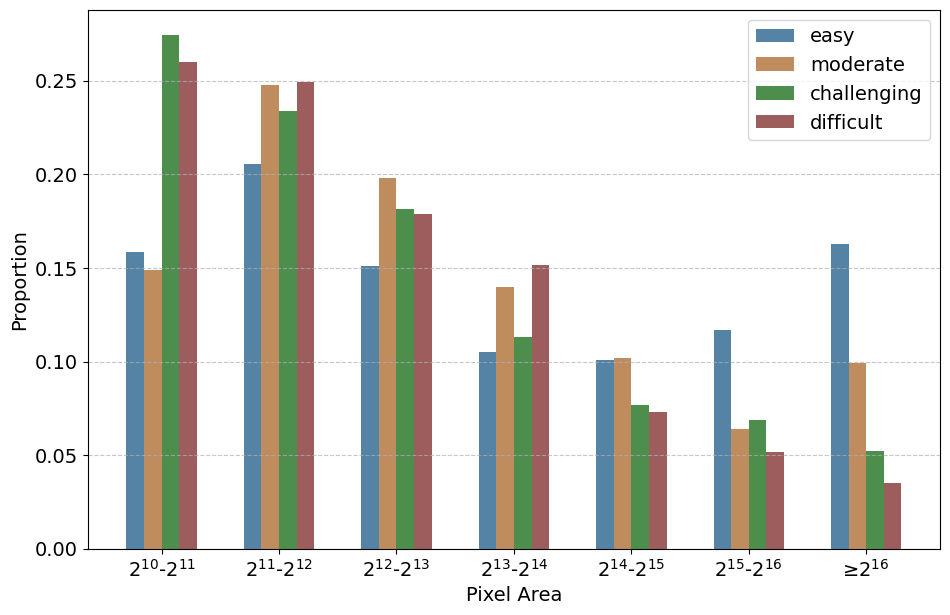

In [36]:
custom_bins = [0, 2048, 4096, 8192, 16384, 32768, 65536, np.inf]
bin_labels = [
    r'$2^{10}$-$2^{11}$', 
    r'$2^{11}$-$2^{12}$', 
    r'$2^{12}$-$2^{13}$', 
    r'$2^{13}$-$2^{14}$', 
    r'$2^{14}$-$2^{15}$', 
    r'$2^{15}$-$2^{16}$', 
    r'≥$2^{16}$']

# 计算每个区间的比例
easy_data = area_idx["easy"]
easy_hist, _ = np.histogram(easy_data, bins=custom_bins)
easy_prop = easy_hist/len(easy_data)

moderate_data = area_idx["moderate"]
moderate_hist, _ = np.histogram(moderate_data, bins=custom_bins)
moderate_prop = moderate_hist/len(moderate_data)

challenging_data = area_idx["challenging"]
challenging_hist, _ = np.histogram(challenging_data, bins=custom_bins)
challenging_prop = challenging_hist/len(challenging_data)

difficult_data = area_idx["difficult"]
difficult_hist, _ = np.histogram(difficult_data, bins=custom_bins)
difficult_prop = difficult_hist/len(difficult_data)

# 设置绘图
plt.figure(figsize=(11, 7))

# 设置x轴位置
x = np.arange(len(bin_labels))
width = 0.15  # 每个柱的宽度

colors = ['#5483a5', '#bf8c5e', '#4d8e4d', '#9d5d5d', '#8c8cb6', '#806c68', '#c190c1', '#8c8c8c']

# 绘制柱状图
plt.bar(x - 1.5*width, easy_prop, width, label='easy', color=colors[0])
plt.bar(x - 0.5*width, moderate_prop, width, label='moderate', color=colors[1])
plt.bar(x + 0.5*width, challenging_prop, width, label='challenging', color=colors[2])
plt.bar(x + 1.5*width, difficult_prop, width, label='difficult', color=colors[3])

# 添加标签和网格
plt.xlabel('Pixel Area', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(x, bin_labels, rotation=0,fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加图例
plt.legend(fontsize=14)

# 优化布局
# plt.tight_layout()
plt.savefig('./pixel_range.svg', format='svg')
plt.show()